<a href="https://colab.research.google.com/github/abharr/Abby-Neur-265/blob/main/Copy_of_04_12_23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Calcium Imaging - Part Deux

In our first notebook on calcium imaging, we talked about what calcium imaging is, how neuroscientists do it, and then we related traces from individual ROIs (cells) to spatial positions in the zebrafish brain. In this notebook, we will build off of what we learned to relate fluorescent signals to behavior, both in the zebrafish (2-photon imaging) and in the mouse (1-photon imaging). 

##By the end of this notebook, you will be able to:

- Evaluate relationships between fluorescent signal and stimulus input
- Relate these fluorescent signals back to areas of the brain
- Isolate event-related fluorescenct signals from multiple neurons in the mouse brain during fear conditioning

##Introduction

We will be working with two datasets today. The first dataset contains fluorescent signal from a zebrafish brain during LED (light) pulses. The second dataset contains fluorescent signal from multiple neurons imaged in the mouse anterior cingulate cortex (ACC) during fear conditioning - a paradigm in which the mouse is placed in an chamber and given brief foot-shocks that coincide with an auditory tone. For our mouse dataset, as in our previous notebook, ROIs have already been extracted - what we now have to do is evaluate the 
ΔF/F signals from each ROI. For our zebrafish dataset, we're going to start with a raw imaging movie and extract fluorescent traces. 

In [1]:
# Import a buncha modules!

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import copy
from scipy.stats import pearsonr
import matplotlib as mpl
from matplotlib.ticker import FixedLocator
from matplotlib.colorbar import Colorbar
from skimage import io
import matplotlib.ticker as mticker
import os 
import random
import time
from matplotlib import gridspec

Let's start by importing the movie from our shared Google Drive folder:

In [2]:
# Mount Google Drive to access its folders

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [18]:
# Import the video (hint: put the path to your file in the string)
LED_video = io.imread('/content/drive/MyDrive/zebrafish_movie.tif')

Let's first make a helper function to normalize our data:

In [19]:
def normalizeData(data):
    if type(data).__module__ == np.__name__: # if we work with numpy data
        normVector = (data - data.min())/(data.max() - data.min())
        return normVector
    
    dataCopy = copy.deepcopy(data)
    for i in range(len(dataCopy)):
        min_data = np.min(dataCopy.iloc[i])
        max_data = np.max(dataCopy.iloc[i])
        tt = (np.array(dataCopy.iloc[i]) - min_data) / (max_data - min_data)
        dataCopy.iloc[i] = tt
    return dataCopy

And now, a function to model the shape of the LED input (sudden onset with exponential decay):

In [20]:
def modelOnset(tau=200, phase = 300, n=700):
    onset_model = np.zeros(n) # pre-allocatre memory with empty array of zeros
    decay = lambda t: np.exp(-t/tau) # exponential decay
    vfunc = np.vectorize(decay)
    onset_model[phase:] = vfunc(np.array(range(phase, n))) # in our experiment LED turns on at frame 300
    
    return onset_model

Let's now display the first frame of the video file that we imported from Google Drive:

Video shape:  (700, 136, 159)


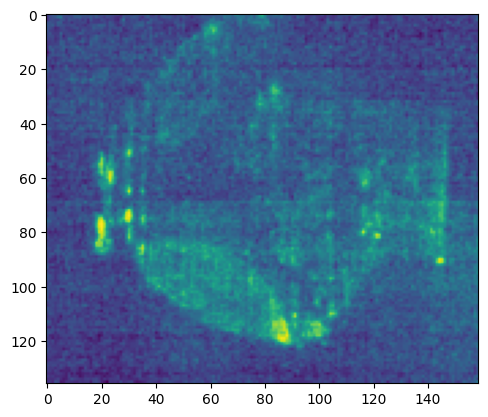

In [38]:
print("Video shape: ", LED_video.shape)

LED_video_frames = LED_video.shape[0]
LED_video_y_pixels = LED_video.shape[1]
LED_video_x_pixels = LED_video.shape[2]

video_first_frame = copy.deepcopy(LED_video[0])
video_second_frame = copy.deepcopy(LED_video[1])
video_third_frame = copy.deepcopy(LED_video[2])
video_fourth_frame = copy.deepcopy(LED_video[3])
video_nth_frame = copy.deepcopy(LED_video[509])
plt.imshow(video_nth_frame);

><b>Task:</b> Try creating an image of a bunch of other video frames. How do the frames change as you progress through the movie?

We're now going to take our movie, and extract all of the pixels frame-by-frame. We're going to store each pixel in a new <code>numpy</code> array.

In [39]:
# Empty arrays to store information about video
coordinates_list_LED = []
activity_matrix_LED = np.zeros((LED_video_y_pixels * LED_video_x_pixels, LED_video_frames))
pixel_coordinates_LED = np.zeros((LED_video_y_pixels * LED_video_x_pixels, 2)) #two columns for x and y coords
pixel_counter_LED = 0

startTime = time.time()
# load data pixel-by-pixel into a numpy array
for i in range(LED_video_y_pixels): 
    for j in range(LED_video_x_pixels):
        activity = np.array(LED_video[:, i, j])
                        
        activity_matrix_LED[pixel_counter_LED] = normalizeData(activity) 
        pixel_coordinates_LED[pixel_counter_LED] = np.array([j,i])
        coordinates_list_LED.append((j,i))
        
        pixel_counter_LED += 1
        
print("Run time: {0} seconds".format(time.time() - startTime))

Run time: 0.64109206199646 seconds


And now convert our <code>numpy</code> array into a <code>pandas</code> dataframe:

In [40]:
columns = range(1, activity_matrix_LED.shape[1]+1) # setting column values to be frame numbers
columns = ["{:02d}".format(x) for x in columns]

# convert numpy to panda data frame:
df = pd.DataFrame(data=activity_matrix_LED, columns=columns)
# last column represents coordinates:
df['coords'] = coordinates_list_LED

# show top 5 rows:
df.head()

,01,02,03,04,05,06,07,08,09,10,...,692,693,694,695,696,697,698,699,700,coords
0,0.408984,0.421968,0.540733,0.569459,0.479471,0.470246,0.556475,0.438061,0.604402,0.270016,...,0.529453,0.393944,0.447636,0.298441,0.510252,0.624956,0.453502,0.328872,0.606457,"(0, 0)"
1,0.847902,0.509877,0.148483,0.324790,0.710394,0.598063,0.763331,0.308522,0.655778,0.287734,...,0.525759,0.917560,0.489154,0.363589,0.445513,0.587928,0.403228,0.386507,0.592318,"(1, 0)"
2,0.832665,0.419121,0.456003,0.436952,0.620143,0.570599,0.651043,0.653482,0.350119,0.258524,...,0.492885,0.756926,0.560260,0.665737,0.569379,0.403671,0.640762,0.404426,0.645118,"(2, 0)"
3,0.484298,0.317253,0.496343,0.425337,0.457182,0.318136,0.520053,0.440850,0.191575,0.346134,...,0.129966,0.395195,0.259995,0.567411,0.184260,0.260436,0.558772,0.089545,0.219574,"(3, 0)"
4,0.603375,0.359790,0.527626,0.038376,0.291439,0.655467,0.415042,0.527086,0.536025,0.398243,...,0.234569,0.403945,0.045773,0.745396,0.223549,0.271943,0.632272,0.156199,0.583340,"(4, 0)"


><b>Task:</b> Find the <code>shape</code> of your new dataframe (<code>df</code>). Why does the number of rows make sense? For reference, look 3 code cells above where you calculated the shape of the raw video.

In [41]:
# Figure out the shape of your dataframe
print(df.shape)

(21624, 701)


><b>Task:</b> Create a variable called <code>time</code>. The sampling rate of the camera used to image these data was 5 fps. Use this information to make the last column of your <code>time</code> variable equal to the length of the imaging session, in seconds, with a length equal to the number of frames in the video.

In [44]:
# Make your time variable here!
t = 700/5
time = np.linspace(0,t,num=700)

##Showing Spatial Information for Each Pixel

Let's extract the traces from four example ROIs, and show where those ROIs are located in our original imaging movie:

Text(0.5, 0, 'seconds')

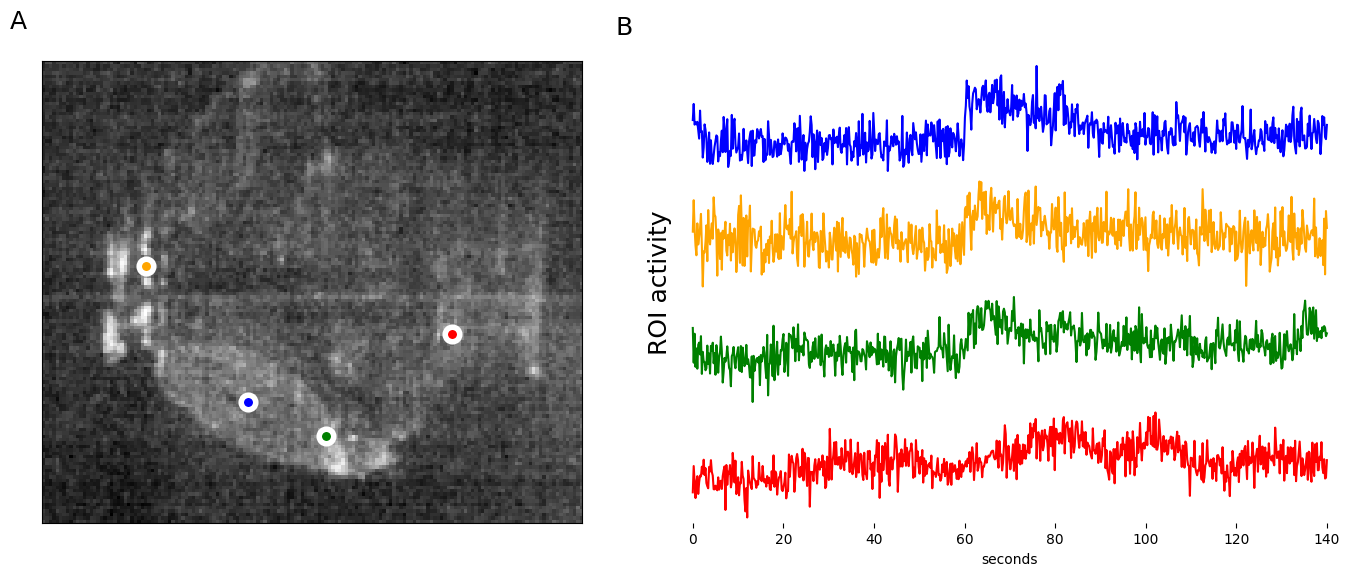

In [45]:
# pick sample pixels by coordinates, assign color to each
example_rois = {(60, 100):'blue', (30,60):'orange', (83, 110):'green', (120,80):'red'}

# define size and background color of the figure
fig = plt.figure(constrained_layout=False, figsize=(18,6))
fig.patch.set_facecolor('white')

# create grid layout with 4 rows and 2 columns
gs = fig.add_gridspec(4, 2, hspace=0, wspace= 0)

# first subplot will occupy 4 rows in the 1st column
ax1 = fig.add_subplot(gs[0:4, 0])
ax1.text(-10, -10, 'A', size=18)

# turn off axis and labels
ax1.axes.yaxis.set_visible(False)
ax1.axes.xaxis.set_visible(False)
ax1.imshow(video_first_frame, cmap='gray') #showing the first frame 

for roi in range(0, len(example_rois)):

    ax = fig.add_subplot(gs[roi, 1])

    key = list(example_rois.keys())[roi]
    pixel_activity = np.array(df.loc[df['coords'] == (key[0], key[1])])[0][:700] #collecting activity from the dataframe 
    ax.plot(time, pixel_activity, color=example_rois[key])
    ax.axis('off')
    # add roi location to the image
    ax1.scatter(key[0],key[1],s=110, facecolor=example_rois[key], edgecolor='white', linewidths=4)
    if roi==0:
        ax.text(-17, 1.3, 'B', size=18)


ax.text(-10, 1.6, 'ROI activity', size=18,rotation='vertical')

# turn axes back on for the last line plot
ax.axis('on')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axes.yaxis.set_visible(False)
ax.set_xlabel('seconds')

##Fitting the LED Model to the Data

We would now like to see which pixels generate a fluorescent signal that mimics the LED. If we find such pixels, we could conclude that the areas of the brain where the pixels are respond to light input. To do this, we'll first make our LED model:

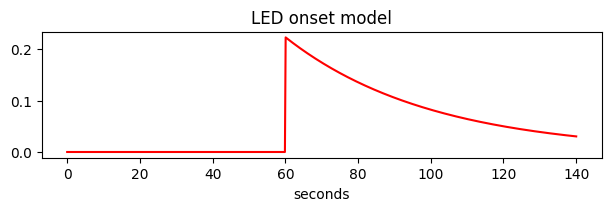

In [46]:
fig = plt.figure(constrained_layout=True, figsize=(6,2));
plt.plot(time, modelOnset(), color='red', label='onset model')
plt.title('LED onset model');
plt.xlabel('seconds');

And then try fitting it to our data by correlating each pixel's ΔF/F trace with the LED signal:

In [47]:
correlation_onset = [] # saving coordinates and correlation coefficient of pixels
correlation_map = np.zeros((LED_video_y_pixels, LED_video_x_pixels)) # image that holds correlation values per pixel 

for i in range(len(df)):
    activity_correlation = np.array(df.iloc[i])[:700] # pixel activity
    activity_coordinates = df.iloc[i]['coords']       # pixel coordinates 
    
    p_onset = pearsonr(activity_correlation, modelOnset())[0] #grabbing r corr value
    
    # only save pixels that have correlation with model > 0.7
    if (p_onset**2) > .7:
        correlation_onset.append([activity_coordinates, p_onset**2]) #adding activity of correlated pixels
        
    correlation_map[activity_coordinates[1], activity_coordinates[0]] = p_onset ** 2 #y direction first, x direction when indexing video

    correlation_LED_indices = [] #indices of correlated pixes in main dataframe 
for i in range(len(correlation_onset)):
    correlation_LED_indices.append(df[df['coords'] == correlation_onset[i][0]].index.tolist()[0]) #gives back array so indexing 0 

correlation_onset_df = df.iloc[correlation_LED_indices] #creating data subset 
correlation_onset_df.head()


,01,02,03,04,05,06,07,08,09,10,...,692,693,694,695,696,697,698,699,700,coords
14678,0.287832,0.263646,0.064140,0.331784,0.299600,0.161796,0.088326,0.329996,0.217256,0.365950,...,0.232795,0.368616,0.106076,0.164884,0.366633,0.272520,0.373720,0.216833,0.276519,"(50, 92)"
14679,0.339306,0.396516,0.078711,0.299078,0.237193,0.109124,0.295245,0.144210,0.184438,0.259940,...,0.280381,0.166989,0.254830,0.144023,0.283778,0.311199,0.248878,0.293562,0.235043,"(51, 92)"
14838,0.277971,0.211044,0.207049,0.163630,0.185662,0.222567,0.047199,0.271456,0.157330,0.071321,...,0.154811,0.312571,0.204744,0.110346,0.223212,0.306487,0.208524,0.230556,0.128814,"(51, 93)"
14839,0.341507,0.251881,0.308774,0.254938,0.252091,0.234495,0.124607,0.111298,0.270316,0.218339,...,0.098198,0.339888,0.310422,0.251881,0.135667,0.329037,0.209946,0.262942,0.145889,"(52, 93)"
14840,0.317784,0.272487,0.334955,0.204961,0.146005,0.272713,0.124678,0.268524,0.181637,0.205187,...,0.236179,0.122036,0.236405,0.183860,0.358022,0.225644,0.151289,0.334504,0.134794,"(53, 93)"


Now that we've pulled out the pixels that are highly correlated with our LED stimulus, we can plot them as a function of space on the raw video:

Text(0.5, 0, 'seconds')

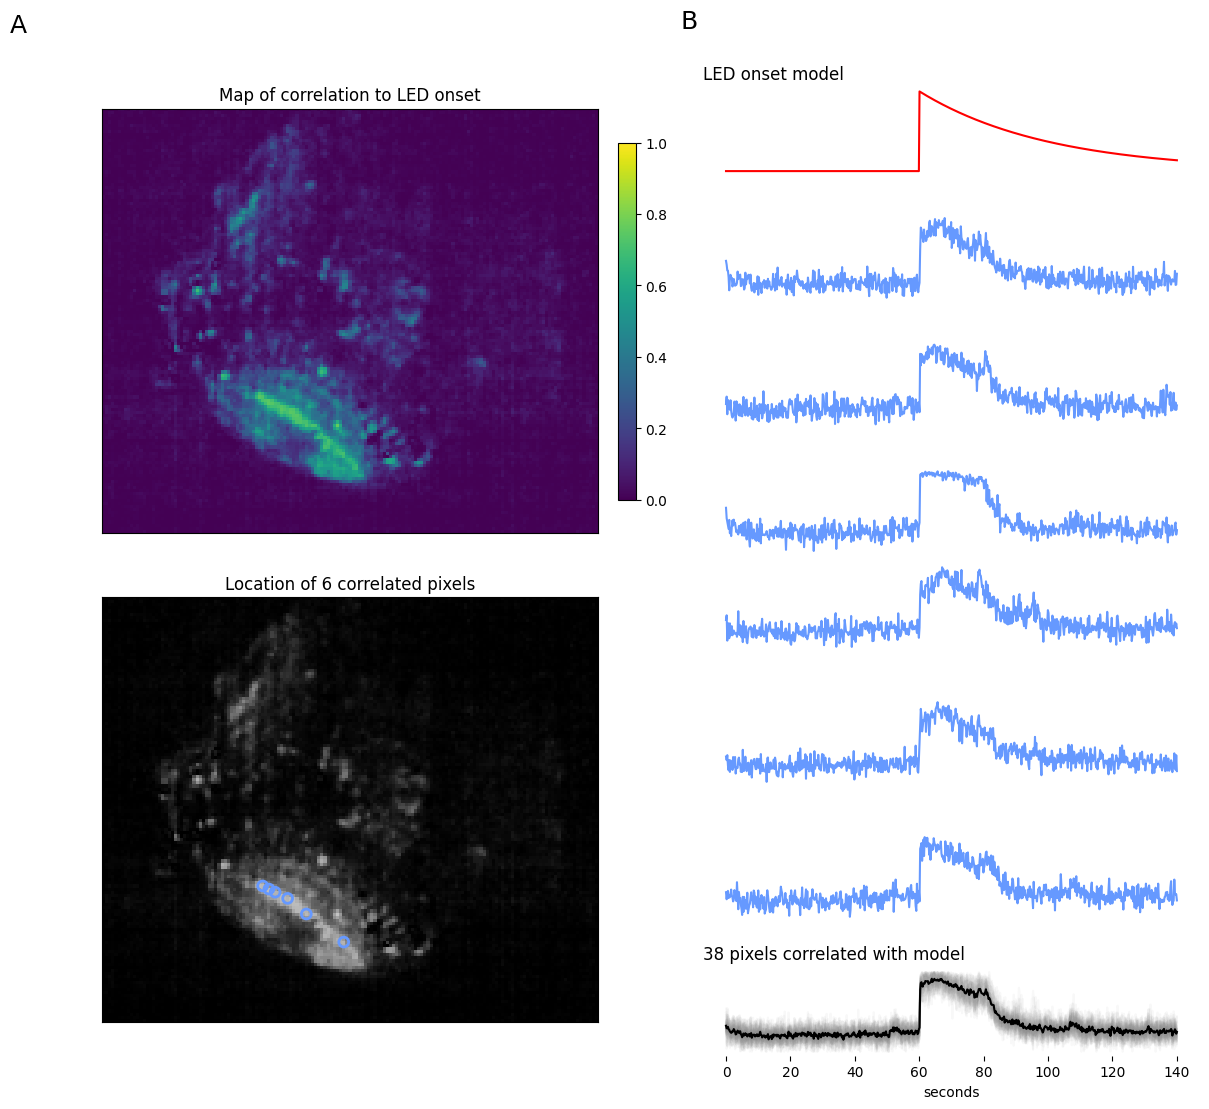

In [50]:
np.random.seed(1234) # fix seed so that result is the same each time
example_correlated_pixels = np.random.choice(range(0, len(correlation_onset_df)),size=6, replace=False)

fig = plt.figure(constrained_layout=True, figsize=(12,11))
fig.patch.set_facecolor('white')

nrow = 8 
ncol = 2

gs = fig.add_gridspec(nrow, ncol, width_ratios=[1, 1])

ax1 = fig.add_subplot(gs[0:4, 0])
ax1.set_title('Map of correlation to LED onset')
ax1.axes.yaxis.set_visible(False)
ax1.axes.xaxis.set_visible(False)

# add "subfigure" label
ax1.text(-30, -25, 'A', size=18)
plt1 = ax1.imshow(correlation_map, cmap='viridis', vmin=0.0, vmax=1.0) #displaying the correlation map
fig.colorbar(plt1, ax=ax1,fraction=0.036, pad=0.04)



ax2 = fig.add_subplot(gs[4:8, 0])
ax2title = 'Location of {0} correlated pixels'.format(len(example_correlated_pixels))
ax2.set_title(ax2title)
ax2.axes.yaxis.set_visible(False)
ax2.axes.xaxis.set_visible(False)
plt2 = ax2.imshow(correlation_map, cmap='gray', vmin=0.0, vmax=1.0)
#fig.colorbar(plt2, ax=ax2)


for pixel_ind in example_correlated_pixels: #displaying the spatial location of example correlated pixels
    ax2.scatter(correlation_onset_df.iloc[pixel_ind]['coords'][0], 
                correlation_onset_df.iloc[pixel_ind]['coords'][1], 
                s=50, facecolor='none', edgecolor='#6699ff', linewidths=2)

ax3 = fig.add_subplot(gs[0, 1])
ax3.plot(modelOnset(), color='red', label='onset model') #plotting the LED onset model 
ax3.set_title('LED onset model', loc='left')
ax3.axis('off')
ax3.text(-70, 0.4, 'B', size=18)

# for each ROI out of 6 we will plot line profile:
for roi in range(0,6):
    ax_roi = fig.add_subplot(gs[1+roi, 1])
    x_roi = correlation_onset_df.iloc[example_correlated_pixels[roi]]['coords'][0]
    y_roi = correlation_onset_df.iloc[example_correlated_pixels[roi]]['coords'][1]
    pixel_activity = np.array(LED_video[:, y_roi, x_roi]) #collecting activity from the pixel in LED video
    ax_roi.plot(pixel_activity, color='#6699ff')
    ax_roi.axis('off')


# overlay all traces with correlation > 0.7 to show spread:
ax_overlay = fig.add_subplot(gs[7,1])
for i in range(len(correlation_onset_df)):
    ax_overlay.plot(time, correlation_onset_df.iloc[i][:700], color='gray', alpha=.05)

# calculate average activity of pixels correlated with model
average_activity = np.array(correlation_onset_df.drop('coords', axis=1).mean(axis=0))
ax_overlay.plot(time, average_activity, color='black')
ax_overlay.spines['top'].set_visible(False)
ax_overlay.spines['right'].set_visible(False)
ax_overlay.spines['bottom'].set_visible(False)
ax_overlay.spines['left'].set_visible(False)
ax_overlay.axes.yaxis.set_visible(False)
ax_overlay_title = '{0} pixels correlated with model'.format(len(correlation_onset_df))
ax_overlay.set_title(ax_overlay_title, loc='left')
ax_overlay.set_xlabel('seconds')


Question: Is there a relationship between pixels that respond to the LED input and location in the zebrafish pallium?

##Mouse Fear Conditioning Data

We're going to switch gears a bit now and look at 1-photon miniscope imaging data from the mouse ACC during fear conditioning - specifically, when the mouse is learning to associate a brief (2 s) foot-shock with a tone. 

<img src = 'https://drive.google.com/uc?id=1xdzq1ctctB9cY0S5VdiJtOErDKUcVaNS'>

We used a miniature 1-photon miniscope to image GFP signals from ACC neurons during the entire conditioning session. We are interested to know if these signals correspond to events during the session - specifically, the tone, and the shock.

Let's import the extracted ROI traces from our GitHub repo. To do this, import the <code>fear_traces.csv</code> file as a <code>numpy</code> array called <code>fear_traces</code>.

In [53]:
# Import your fluorescent traces!
fear_traces = np.loadtxt('https://raw.githubusercontent.com/hallockh/neur_265/main/fear_traces.csv',delimiter=',')

><b>Task:</b> Look at the <code>shape</code> of your <code>fear_traces</code> variable. Columns correspond to individual cells, and rows correspond to samples. The sampling miniscope's sampling rate is 15 fps. How many cells do we have in our array? What is the length of the conditioning session?

In [55]:
# Your code here!
print(fear_traces.shape)


(10458, 10)


><b>Task:</b> Create a <code>time</code> variable for your imaging data. Plot fluorescent traces from the first two cells in your <code>fear_traces</code> array in one plot, with time on the x-axis. Label your axes.

In [57]:
# Your code here!
t1 = 10458/15
time1 = np.linspace(0,t1,num=10458)

Question: Do you notice any time periods where the fluorescent intensity tends to go up or down?

><b>Task:</b> Next, we need some way of knowing when tones and shocks occurred. The <code>shock_index.csv</code> and <code>tone_index.csv</code> files on our GitHub repo provide us with timesetamps for each tone and each shock during the conditioning session. Import those files as <code>numpy</code> arrays called <code>shock_index</code> and <code>tone_index</code>, respectively.

In [64]:
# Import your indices

shock_index = np.loadtxt('https://raw.githubusercontent.com/hallockh/neur_265/main/shock_index.csv', delimiter = ',').astype(int)
tone_index = np.loadtxt('https://raw.githubusercontent.com/hallockh/neur_265/main/tone_index.csv', delimiter = ',').astype(int)
print(shock_index)

[358 448 538]


><b>Task:</b> Make a plot with the fluorescent trace from the first cell, and black horizontal lines at times that the mouse received a foot-shock. Put time on the x-axis. Do you notice any changes in fluorescent activity during these timepoints?

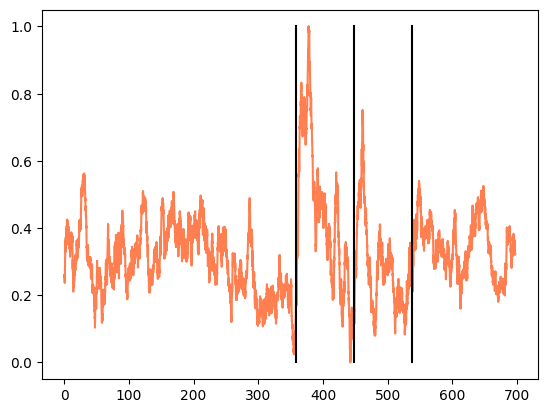

In [73]:
# Make your plot here!
plt.plot(time1,fear_traces[:,0],color='coral')
plt.plot([358,358],[0,1],color='black')
plt.plot([448,448],[0,1],color='black')
plt.plot([538,538],[0,1],color='black')

Another way of visualizing this would be to isolate snippets of the fluorescent trace from each cell surrounding shock onset and tone onset, and looking at them altogether in a heatmap.

Text(0.5, 0, 'Time from Tone Onset [s]')

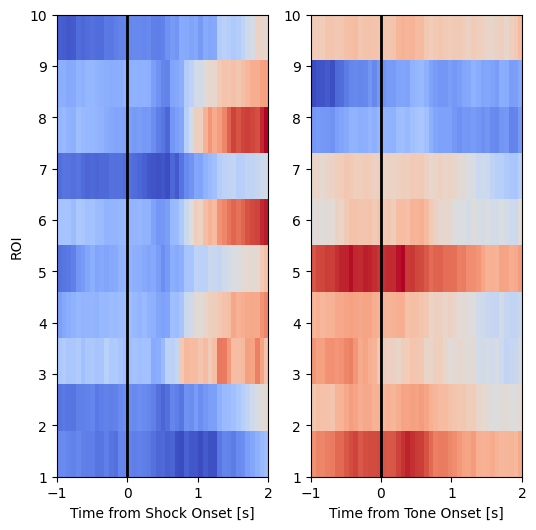

In [74]:
# Let's isolate our shock-centered and tone-centered data

# Initialize variables
shock_temp = np.zeros((45, 3))
shock_traces = np.zeros((45, 10))
tone_temp = np.zeros((45, 3))
tone_traces = np.zeros((45, 10))

# Make a meaningful x-axis for our plots
xaxis = np.linspace(-1,2,45)

# Grab fluorescence surrounding shock onset for each ROI
for i in range(10):
  for j in range(3):
    shock_temp[:,j] = fear_traces[(shock_index[j]-1)*15:(shock_index[j]+2)*15,i]
  shock_traces[:,i] = np.mean(shock_temp, axis = 1)

# Grab fluorescence surrounding tone onset for each ROI
for i in range(10):
  for j in range(3):
    tone_temp[:,j] = fear_traces[(tone_index[j]-1)*15:(tone_index[j]+2)*15,i]
  tone_traces[:,i] = np.mean(tone_temp, axis = 1)

f, a = plt.subplots(1,2,figsize=(6, 6))

a[0].imshow(np.transpose(shock_traces), cmap = 'coolwarm', extent=[xaxis[0], xaxis[-1], 1, 10], aspect = 'auto')
a[0].plot([0, 0], [1,10], 'k', lw=2) # Make a black line at shock onset
a[0].set_xlabel('Time from Shock Onset [s]')
a[0].set_ylabel('ROI')

a[1].imshow(np.transpose(tone_traces), cmap = 'coolwarm', extent=[xaxis[0], xaxis[-1], 1, 10], aspect = 'auto')
a[1].plot([0, 0], [1,10], 'k', lw=2) # Make a black line at tone onset
a[1].set_xlabel('Time from Tone Onset [s]')



It looks like cells in the ACC have a consistent relationship with shock onset, and a less consistent relationship with tone onset.

##Modeling our Fear Data

To see whether tone presentation, shock presentation, or a combination of the two affect cellular activity in the ACC during conditioning, we can use generalized linear modeling (GLM) with tone onset and shock onset as covariates. We've already learned that spiking tends to approximate a Poisson (random) distribution. Since calcium-induced fluorescence is closely tied to spiking (though not equal to spiking!), we can also assume that our fluorescent signal approximates a Poisson distribution. When looking at our first fluorescent trace, we notice that fluorescence seems to increase exponentially shortly following shock onset. 

The first thing we need to do is make our <code>predictor</code> (covariates in the model) arrays. To do that, we'll need to make one array for shock onset, and one array for tone onset. We'll make both arrays equal to the length of our fluorescent trace data (10458 samples). Since shock events and tone events are binary (a tone/shock is either happening, or it's not), we'll populate our arrays with "zeros" when tones/shocks aren't happening, and "ones" when they are.

In [75]:
shock_array = np.zeros(10458)
for i in range(10458):
  if i >= (shock_index[0]-15)*15 and i <= (shock_index[0]+30)*15:
    shock_array[i] = 1
  elif i>= (shock_index[1]-15)*15 and i <= (shock_index[1]+30)*15:
    shock_array[i] = 1
  elif i>= (shock_index[2]-15)*15 and i <= (shock_index[2]+30)*15:
    shock_array[i] = 1
  else:
    shock_array[i] = 0

tone_array = np.zeros(10458)
for i in range(10458):
  if i >= (tone_index[0]-15)*15 and i <= (tone_index[0]+30)*15:
    tone_array[i] = 1
  elif i>= (tone_index[1]-15)*15 and i <= (tone_index[1]+30)*15:
    tone_array[i] = 1
  elif i>= (tone_index[2]-15)*15 and i <= (tone_index[2]+30)*15:
    tone_array[i] = 1
  else:
    tone_array[i] = 0

Let's first make a model that uses only tone onset as a predictor, and see how it does with the fluorescent trace from the first ROI:

In [76]:
from pandas import DataFrame as df
import statsmodels.api as sm
from statsmodels.genmod.families import Poisson
from statsmodels.genmod.families.links import identity, log
from scipy.stats import chi2
from statsmodels.distributions.empirical_distribution import ECDF

first_trace = fear_traces[:,0]

predictors = df(data={'Intercept': np.ones_like(tone_array), 'tone onset': tone_array})
model1 = sm.GLM(first_trace, predictors, family=Poisson())
model1_results = model1.fit() # Fit model to our data
b1 = model1_results.params
print('b1:')
print(b1)

b1:
Intercept    -1.047509
tone onset   -0.430994
dtype: float64


To see how our model did, we can plot the model's predicted fluorescent trace on top of the actual trace from our first ROI:

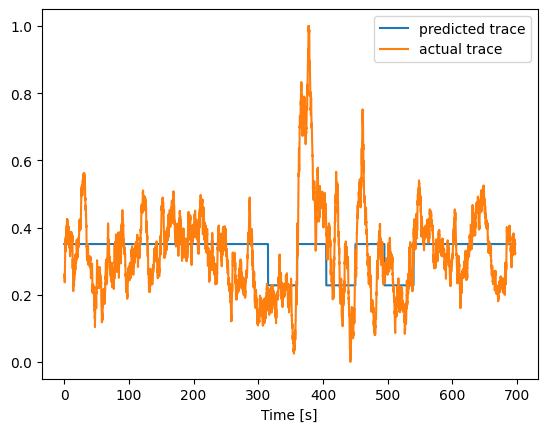

In [79]:
# Plottin' tone onset model results

plt.plot(time1, model1_results.predict(), label = "predicted trace")
plt.plot(time1, first_trace, label = "actual trace")
plt.xlabel('Time [s]')
plt.legend()

Not so great! This might have been predictable for a few reasons: 

1) We saw from our visualizations above that there seemed to be an inconsistent relationship between tone onset and calcium fluorescence in our population, and

2) Tone onset only accounts for three timepoints during the imaging session.

Let's see what happens when we make a second model with shock onset as the predictor:

In [80]:
predictors2 = df(data={'Intercept': np.ones_like(shock_array), 'shock onset': shock_array})
model2 = sm.GLM(first_trace, predictors2, family=Poisson())
model2_results = model2.fit() # Fit model to our data
b2 = model2_results.params    # Get the predicted coefficient vector
print('b2:\n', b2)

b2:
 Intercept     -1.158997
shock onset    0.196195
dtype: float64


Let's plot the relationship between predicted fluorescence and actual fluorescence for this model:

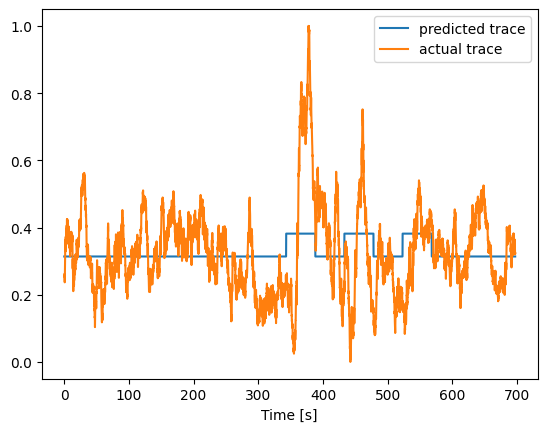

In [82]:
# Plottin' shock onset model results

plt.plot(time1, model2_results.predict(), label = "predicted trace")
plt.plot(time1, first_trace, label = "actual trace")
plt.xlabel('Time [s]')
plt.legend()

It seems like this neuron isn't just responding to shock onset or tone onset. Maybe it responds to a combinaton of the two? To test this, we'll add both into our <code>predictors</code> variable, and re-run our model:

In [83]:
predictors['shock onset'] = shock_array
model3 = sm.GLM(first_trace, predictors, family=Poisson())
model3_results = model3.fit() # Fit model to our data
b1 = model3_results.params
print('b1:')
print(b1)


b1:
Intercept     -1.098020
tone onset    -0.503819
shock onset    0.297597
dtype: float64


And plot expected vs. actual traces:

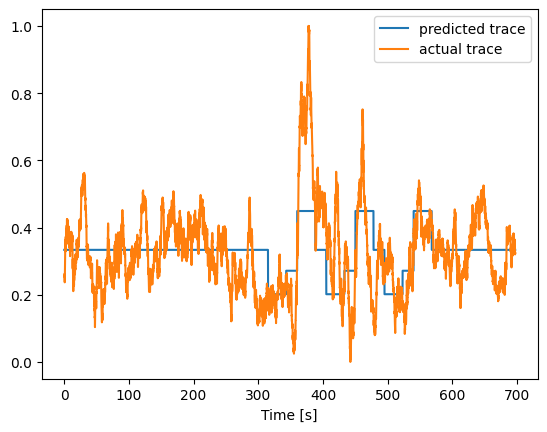

In [84]:
# Plottin' tone and shock onset model results

plt.plot(time1, model3_results.predict(), label = "predicted trace")
plt.plot(time1, first_trace, label = "actual trace")
plt.xlabel('Time [s]')
plt.legend()

We see that this model seems to capture a lot of the broad variation in fluorescence we see after the first tone. It makes our predicted signal is completely flat outside of these time periods - there aren't any covariates at these times, so the model has nothing to fit. There are likely some continuous variables we could add to the model - for example, the animal's motion, head direction, etc. - that would account for more of the variation in fluorescence outside of the tone/shock periods. 

Recall that we can test goodness-of-fit between nested models with chi-square tests. Let's see how our third model holds up against the first two models:

In [85]:
dev1 = model1_results.deviance
dev2 = model2_results.deviance
dev3 = model3_results.deviance
p1 = 1 - chi2.cdf(dev1 - dev3, 1)  # Compare Models 1 and 3, nested GLMs.
p2 = 1 - chi2.cdf(dev2 - dev3, 1)  # Compare Models 2 and 3, nested GLMs.
print(p1)
print(p2)

4.091060823441239e-12
0.0


Another powerful way of analyzing how well a model performs for an entire population of neurons is to calculate the correlation between the model's predicted trace and the actual trace for each neuron, and plot the resulting *r* values as a cumulative distribution for each model:

Text(0, 0.5, 'Cumulative Proportion of ROIs')

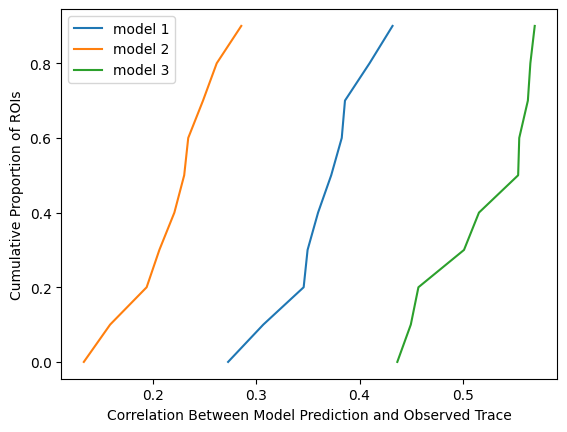

In [86]:
# Get cumulative distribution of r values for model 1 (just tone onset)

predictors = df(data={'Intercept': np.ones_like(tone_array), 'tone onset': tone_array})
r_model1 = np.zeros(10)

for i in range(10):
  trace_temp = fear_traces[:,i]
  model1 = sm.GLM(trace_temp, predictors, family=Poisson())
  model1_results = model1.fit()
  predicted_trace = model1_results.predict()
  r1 = pearsonr(trace_temp, predicted_trace)
  r_model1[i] = r1.statistic

# For model 2

predictors2 = df(data={'Intercept': np.ones_like(shock_array), 'shock onset': shock_array})
r_model2 = np.zeros(10)

for i in range(10):
  trace_temp = fear_traces[:,i]
  model2 = sm.GLM(trace_temp, predictors2, family=Poisson())
  model2_results = model2.fit()
  predicted_trace = model2_results.predict()
  r2 = pearsonr(trace_temp, predicted_trace)
  r_model2[i] = r2.statistic

# For model 3

predictors['shock onset'] = shock_array
r_model3 = np.zeros(10)

for i in range(10):
  trace_temp = fear_traces[:,i]
  model3 = sm.GLM(trace_temp, predictors, family=Poisson())
  model3_results = model3.fit()
  predicted_trace = model3_results.predict()
  r3 = pearsonr(trace_temp, predicted_trace)
  r_model3[i] = r3.statistic

plt.plot(np.sort(r_model1), np.linspace(0, 1, len(r_model1), endpoint=False), label = "model 1")
plt.plot(np.sort(r_model2), np.linspace(0, 1, len(r_model2), endpoint=False), label = "model 2")
plt.plot(np.sort(r_model3), np.linspace(0, 1, len(r_model3), endpoint=False), label = "model 3")
plt.legend()
plt.xlabel('Correlation Between Model Prediction and Observed Trace')
plt.ylabel('Cumulative Proportion of ROIs')